In [2]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from tqdm import tqdm_notebook
import pickle, secrets
dump_directory = "/home/srivbane/shared/caringbridge/data/projects/place-project/DataResults/"

In [8]:
class Node:
    def __init__(self, val, num):
        self.val = val
        self.filenum = num
        self.next = None
        self.prev = None
        
    def __str__(self):
        return str(self.val)
    
class Chain:
    def __init__(self):
        self.id = secrets.token_hex(nbytes=4)
        self.head = None
        self.lastchange = 0
        self.length = 0
        self.tail = None
        
    def add_node(self,val,num):
        self.length += 1
        node = Node(val, num)
        p1 = self.head
        if p1 == None:
            self.head = node
            self.tail = node
        else:
            node.prev = self.tail
            self.tail.next = node

        self.tail = node
    
    def getlast(self):
        return self.tail
    
    def getlength(self):
        return self.tail.filenum - self.head.filenum

    def merge(self, chain2):
        newChain = Chain()
        p1 = self.head
        p2 = chain2.head
        newChain.lastchange = self.lastchange if self.lastchange > chain2.lastchange else chain2.lastchange
        
        while (p1 != None and p2 != None):
            if p1.filenum  <=  p2.filenum:
                
                if newChain.tail != None and newChain.tail.val == p1.val and newChain.tail.filenum == p1.filenum:
                    pass
                else:
                    newChain.add_node(p1.val, p1.filenum)
                p1 = p1.next
            else:
                if newChain.tail != None and newChain.tail.val == p2.val and newChain.tail.filenum == p2.filenum:
                    pass
                else:
                    newChain.add_node(p2.val, p2.filenum)
                p2 = p2.next
        
        if p1 == None and p2 != None:
            new_chain.tail.next = p2
        if p1 != None and p2 == None:
              new_chain.tail.next = p1

        self.head = newChain.head
        self.tail = newChain.tail
            
    def __str__(self):
        tbr = ""
        p1 = self.head
        while p1 != None:
            tbr += "{}({}) -> ".format(str(p1.val), p1.filenum)
            p1 = p1.next
        if len(tbr) > 2:
            return tbr[:-3] + "\t{}".format(self.id)
        return tbr

In [9]:
def load(minute):
    folder_id = minute//60
    data = pickle.load(open(dump_directory+"LinkingResults/hour-"+str(folder_id)+"/links-"+str(minute).zfill(4)+".res", "rb"))
    return data

def get_merge(data):
    val = data.values()
    count_db = {}
    
    for x in val:
        for y in x:
            if y not in count_db:
                count_db[y] = 1
            else:
                count_db[y] += 1
    
    to_be_returned = []
    for x in count_db:
        if count_db[x] > 1:
            to_be_returned.append(x)
            
    return to_be_returned

def get_splits(data):
    tbr = []
    for x in data:        
        if len(data[x]) > 1:
            tbr.append(x)
    return tbr

def deepcopy(linkedlist):
    new_chain = Chain()
    while linkedlist != None:
        new_chain.add_node(linkedlist.val, linkedlist.filenum)
        linkedlist = linkedlist.next
        
    return new_chain

def getChain(chainid):
    for x in chains_inprogress:
        if x.id == chainid:
            return x
    for y in chains_completed:
        if y.id == chainid:
            return y

In [13]:
chains_inprogress = []
chains_completed = []

linked_chains = []

splits_count = 0
merge_count = 0

for num in tqdm_notebook(range(60)):
    links = load(num)
    
    merging_nodes = get_merge(links)
    splitting_nodes = get_splits(links)
#     print ("Merge:", merging_nodes)
#     print ("Splits:", splitting_nodes)
    merge_count += len(merging_nodes)
    splits_count += len(splitting_nodes)
    for y in links:
        found = False

        for z in chains_inprogress:
            if (z.getlast().val == y) and (z.getlast().val in splitting_nodes) and (z.lastchange != num):
                for x in links[y][1:]:
                    l = deepcopy(z.head)
                    l.add_node(x, num+1)
                    l.lastchange = num
                    chains_inprogress.append(l)

                z.add_node(links[y][0], num+1)
                z.lastchange = num
                found = True

            elif (z.getlast().val == y) and (z.lastchange != num):       
                z.lastchange = num
                found = True
                z.add_node(links[y][0], num+1)

        if not found:                                       # NEW CHAIN STARTING
            for x in range(len(links[y])):
                new_chain = Chain()
                new_chain.add_node(y, num)
                new_chain.add_node(links[y][x], num+1)
                new_chain.lastchange = num
                chains_inprogress.append(new_chain)
    
    temp = {}
    for x in chains_inprogress:
        if x.tail.prev.val in splitting_nodes and x.lastchange == num:
            if x.tail.prev.val in temp:
                temp[x.tail.prev.val].append(x.id)
            else:
                temp[x.tail.prev.val] = [x.id]

        if x.tail.val in merging_nodes and x.lastchange == num:
            if x.tail.val in temp :
                temp[x.tail.val].append(x.id)
            else:
                temp[x.tail.val] = [x.id]

    for x in temp:
        merge = True
        for y in range(len(temp[x])-1):
            if getChain(temp[x][y]).tail.val == getChain(temp[x][y+1]).tail.val:
                (getChain(temp[x][y+1])).merge(getChain(temp[x][y]))
                chains_inprogress.remove(getChain(temp[x][y]))

    to_be_removed = []
    
    for x in range(len(chains_inprogress)):
        if chains_inprogress[x].tail.filenum <= num:
            chains_completed.append(chains_inprogress[x])
            to_be_removed.append(x)
    
    for x in to_be_removed[::-1]:
        chains_inprogress.pop(x)
    

    
print ("Merge Count:", merge_count)
print ("Split Count:", splits_count)
print ("Completed Chains:", len(chains_completed))
print ("In-Progress Chains:", len(chains_inprogress))
print ("Total Chains:", len(chains_completed)+len(chains_inprogress))

chains_completed.extend(chains_inprogress)


Merge Count: 248
Split Count: 251
Completed Chains: 958
In-Progress Chains: 245
Total Chains: 1203


In [ ]:
a = getChain('a93edc03').head
while a != None:
    print (a.val,a.filenum)
    a = a.next
print ("---")
a = getChain('a93edc03').tail
while a != None:
    print (a.val,a.filenum)
    a = a.prev

In [ ]:
for x in chains_inprogress:
    print (x)

In [20]:
def average_length(completed):
    l = 0
    for x in chains_completed:
        l += x.getlength()
    return l/len(chains_completed)
    
def maximum_length(chains_completed):
    max = 0
    for x in chains_completed:
        if x.getlength() > max:
            max = x.getlength()
    return max

def minimum_length(chains_completed):
    min = len(chains_completed)
    for x in chains_completed:
        if x.getlength() < min:
            min = x.getlength()
    return min

def distribution_length(chains_completed):
    distribution = []
    for x in chains_completed:
        distribution.append(x.getlength())
    return distribution

def distribution_histogram(distribution):
    plt.hist(distribution, bins=maximum_length(chains_completed)//5)
    plt.ylabel('Number of Conflicts')
    plt.xlabel('Length of Conflict (minutes)')
    plt.yscale('log') 
    plt.show()

Minimum Length: 1
Maximum Length: 60
Average Length: 13.810473815461346


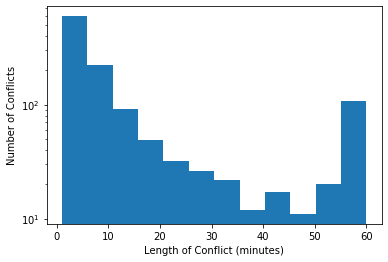

In [21]:
print ("Minimum Length:", minimum_length(chains_completed))
print ("Maximum Length:", maximum_length(chains_completed))
print ("Average Length:", average_length(chains_completed))
distribution_histogram(distribution_length(chains_completed))

In [8]:
from matplotlib import pyplot as plt
import numpy
from tqdm import tqdm_notebook

class Transaction:
    def __init__(self,time,color):
        self.time = time
        self.color = color
    
class Pixel:
    def __init__(self,x,y):
        self.transactions = []
        
    def addTransaction(self, mod):
        self.transactions.append(mod)

# - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - #

rgb_db = {0: (255, 255, 255), 1: (228, 228, 228), 2: (136, 136, 136), 
          3: (34, 34, 34), 4: (255, 167, 209), 5: (229, 0, 0), 6: (229, 149, 0), 
          7: (160, 106, 66), 8: (229, 217, 0), 9: (148, 224, 68), 10: (2, 190, 1), 
          11: (0, 229, 240), 12: (0, 131, 199), 13: (0, 0, 234), 14: (224, 74, 255), 
          15: (130, 0, 128)}

In [9]:
dataset = pickle.load(open("../Visualization/board.dat", "rb"))

plt.rcParams['axes.facecolor'] = 'white'

In [16]:
def generate_emptycanvas(x_range,y_range):
    canvas = numpy.zeros((x_range, y_range, 3), dtype=numpy.uint8)
    for x in tqdm_notebook(range(x_range)):
        for y in range(y_range):
            canvas[x,y] = (255, 255, 255)   
    return (canvas)

def generate_image(time):
    canvas = generate_emptycanvas(1001,1001)

    for x in tqdm_notebook(range(len(dataset))):
        for y in range(len(dataset[x])):
            pixel = dataset[x][y]
            if len(pixel.transactions) > 0:
                for transaction in pixel.transactions:
                    if transaction.time <= time:
                        canvas[y,x] = rgb_db[transaction.color]
    return canvas

def view_conflict(minute, conflict_num):
    data = numpy.zeros( (1001,1001,3), dtype=numpy.uint8)
    color_map = generate_image(1491065400+(60*minute))
    hour = str(minute//60)
    minute = str(minute).zfill(4)
    cluster_data = pickle.load(open("{}ClusterResults/hour-{}/cluster-{}.res".format(dump_directory, hour, minute), "rb"))[conflict_num]
    for x,y in cluster_data:
        data[y][x] = (0, 229, 240)
    fig, axs = plt.subplots(1,2)
    axs[0].imshow(data, interpolation='nearest')
    axs[1].imshow(data, interpolation='nearest')
    axs[1].imshow(color_map, alpha=0.5)
    plt.show()

<IPython.core.display.Javascript object>


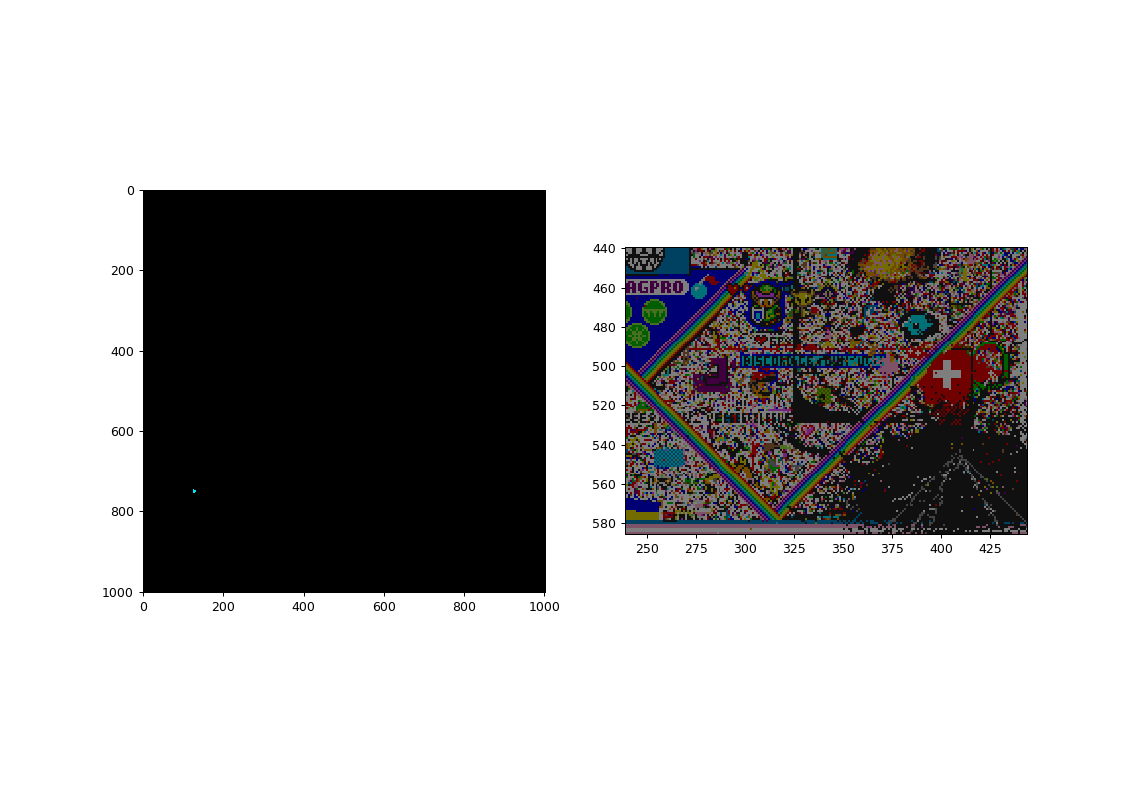

In [19]:
%matplotlib notebook

view_conflict(0, 202)

<IPython.core.display.Javascript object>


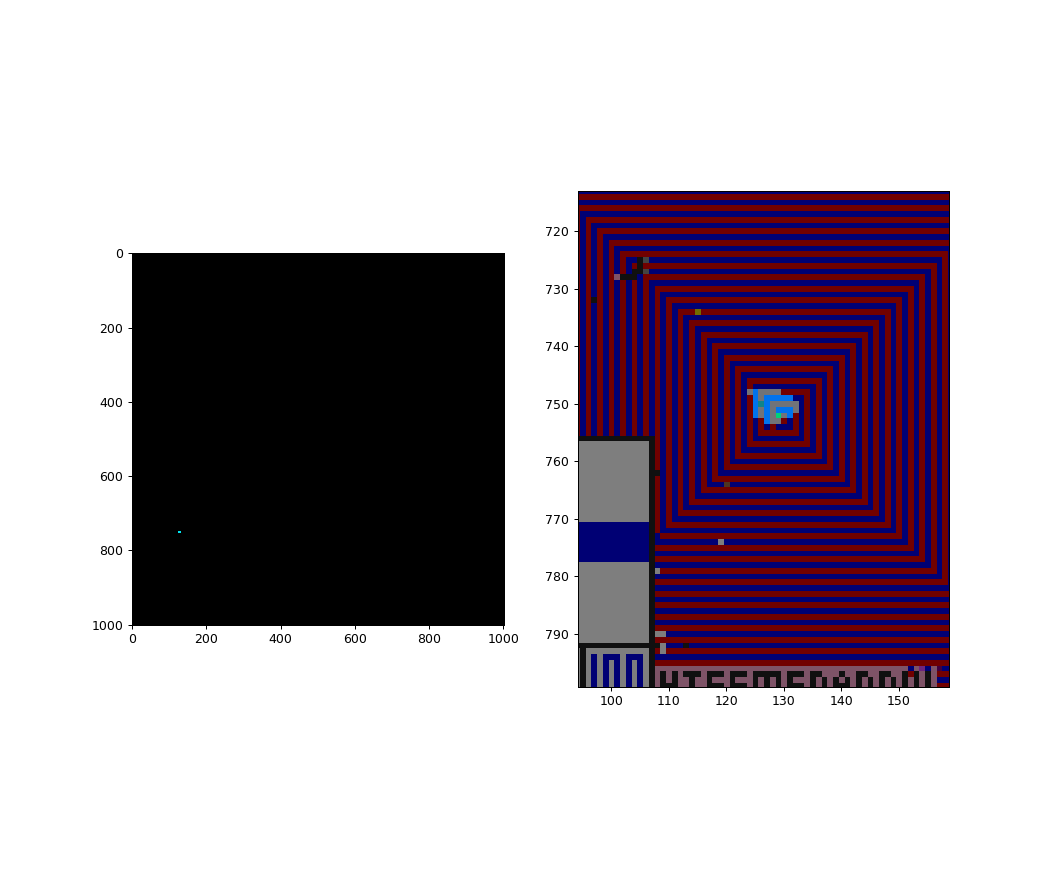

In [18]:
%matplotlib notebook

view_conflict(899, 273)